# Federated Training SCL and GFR datasets

This notebook exhibits training the SimFL model on on both datasets. The intention of this is to provide a benchmark for us to better understand our federated learning results. We follow through the following phases:

- establishing our environment
- preprocessing the data
- training our model
- evaluating our model
- providing predictions on test data

## Establishing our Remote Execution Environment

First we log in to the SAIL backend. This allows us to query for our contracts of interest to see if any remote execution VMs have been initialised for them. We push our safe functions to the respective remote execution VMs and then query for details of the tables they hold. They should both hold unique but valid tables to be processed into training data.  

In [1]:
#First we pull in our tools
from sail.core import VMSetup, registersafeobj,login,connect,pushsafeobj,querydata,get_fns
from sail.data import RemoteDataFrame, Utils, RemoteSeries
from sail.algo import fdxgb

from sail.tmp import shap_private, get_tmp_fns

In [2]:
import time

In [3]:
#We load our safe object storage location
import json, requests
soPath = "/Engineering/Milestone3/EndPointTools/SafeObjectEditor/KPMG/safeobjects"
backendIP = "20.185.6.111"

registersafeobj(soPath)
print("[P]safe objects registered")

[P]safe objects registered


In [4]:
#We log in to the backend using our credentials, receive eosb token
from sail.core import login
eosb = login("adam.hall@secureailabs.com", "-OJBFE2qw-OJBFE2qw", 6200, backendIP)
print("[P]login success")
print(eosb)

[P]login success
5iEQAhtloSPnzcEJkslQN703+gWKtZ2FC1BTwGhM103bujglr7a+hZmkSnKLHupdh5hp9SYDAAC+g9hAsdcFkXZ2EtAmUyHmyOR7mVQDIUZ58nr1p5y/IvdHHmEOFI6hn09MfF0Dw94t8Bom1dZjNvr6uLE6+XeQpYQcPGQsGt7iFCeKtmad7jviyGLUI3NY1ygmrT9ETC/Ag+fotQq6nu4+OnjPxIHp541eDICStEhCUj56+Gl+nmPUVpMYG/O0Ha2J6BMXVhcGdLIJsCbuABLoMXRrRETEIv2dPo6BttQcZ02yPq/IxgU+bpWW5vR+THlzaEUtcBcnsxstRs9KkSNZ648p7hFbBIMORXjK5BIF+x/xLXYdC9b+pMUUdnCdhf1GZ6iUWpQu+EUydSIPu78e6C1GgHfC8AnklGDryd0me/60XtogQitj2jm2BpQHarbjlxR2ljRjdsUSjktdzl6aQgT/g6r0fkqjB0at1C/a7q51RjmtLpUHgjSl7+PZKcu3LQTxpZq1uQxPAKyjHYzc2CIBALTx24xhRncKwTv6KJN7NoePYFlE9tt+pGfIVyEW0M35XrW00inalaX4eRS2aaj2E5dDapqxafTR9xhvslxZgbclsoYErkWhtzuwsvBlgkL0ZmY8ltEPW4NEV++DI+Aa53UkehCNpprrHVS/ZQIq8v93cBZRt73t56wtsexCBzlhQl7elqZUxRFx/U6Njoy45vQz1Tf5rXDl67lDpJ5S0Io7d1dcS5rY414NJhPCw3O5xfgG+88YDHpljXMgMAG3bQGAx2T1bhtmrZIEK+IrXQMEM4yeDnLMYBG/nH3zCNAri8mRDS/42qwTNLXYdy20clpdGiSMb5B0GbYoVfzKUC/MVV6xaZhmLjtj9UzyUttb7Yrsr15Oe4OWzzwqfrYVm3boJPbTYXtF5RhQMWCfZxLify9rRA3sQniqv6tF8PY1Lu7SV/QZdalkqr6

In [5]:
#specify our digital contracts, set our backend ip, query for backend for VMs associated to contracts.
dc = [{"DigitalContractGuid":"{3BFF6633-477E-43D8-B3A3-F3079A1AF10F}"}, {"DigitalContractGuid":"{34E8FF34-2D5E-41C1-ACF4-0106227D88A5}"}]
backendIP = "20.185.6.111"
url = "https://"+backendIP+":6200/SAIL/VirtualMachineManager/GetRunningVMsIpAdresses?Eosb="+eosb

In [6]:
#obtain virtual machines ids and dataset ids, so we can confirm the datasets are intact and ready for studying
import json, requests
payloads = []
for item in dc:
    temp = json.dumps(item)
    payloads.append(temp)

headers = {
    'Content-Type': 'application/json'
}

ips = []
for payload in payloads:
    print(payload)
    response = requests.request("GET", url, headers=headers, data=payload, verify=False)
    print(response)
    response = response.json()
    print(response)
    for key in response['VirtualMachines']:
        ips.append(response['VirtualMachines'][key])
        print(ips)

{"DigitalContractGuid": "{3BFF6633-477E-43D8-B3A3-F3079A1AF10F}"}


/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '20.185.6.111'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>
{'Status': 200.0, 'VirtualMachines': {'578F8FFEA1B0405BAB77648D4FED3EF4': '20.107.19.135'}}
['20.107.19.135']
{"DigitalContractGuid": "{34E8FF34-2D5E-41C1-ACF4-0106227D88A5}"}


/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '20.185.6.111'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>
{'Status': 200.0, 'VirtualMachines': {'BB49DD3519824515AF0E48A0FDA71B71': '51.124.228.170'}}
['20.107.19.135', '51.124.228.170']


In [7]:
#Connect to each IP address in the list of IP addresses returned by the backend
from sail.core import connect

vmids = []
for ip in ips:
    vmid = connect(ip, 3500)
    vmids.append(vmid)
    print("[P]virtual machine connection to ip: {0} success".format(ip))
vmids

[P]virtual machine connection to ip: 20.107.19.135 success
[P]virtual machine connection to ip: 51.124.228.170 success


['{01D67271-1BA1-44C2-A7AB-AAC21B0231D0}',
 '{0AF7E084-1358-4D95-912C-AAF71642911F}']

In [8]:
#Push our safe objects to the remote VMs
from sail.core import get_fns, pushsafeobj

fns = get_fns()
for vm in vmids:
    for key in fns:
        pushsafeobj(vm, fns[key])
print("[P]safe object pushed to virtual machines")
fns

[P]safe object pushed to virtual machines


{'getitem': 'F11C49327A9244A5AEE568B531C6A957',
 'getattr': '9C4019584DB04B1A9BF05EC91836BCB0',
 'setitem': 'A04E4CC9E3BC4A7B9AFAB6CB3E040FAC',
 'iter': 'CC8B5A66C10F47A1A977E2BE2B522768',
 'next': '6D48AC3C3245411992E65E5FF5B90DDB',
 'rdf_describe': '18F2566E7FF34D77A7DE668DD220CEFD',
 'rdf_drop': '9A04D50B403C4716A79CABEF1F90D832',
 'rdf_dropna': '039181877F8A492A86A4BD996D0AD4E2',
 'rdf_merge': '8C938D7D313A49C09509D6A43AAFD096',
 'rdf_groupby': '3E3716FCA7DE4ABEB8A3FAB4DA14EA9D',
 'rdf_query': 'BF18C294BCCC4B9C94624C79D2506CCC',
 'rdf_sort_values': '10DCB6636C8A4832AD6CE7BCDB1F9983',
 'rdf_set_index': '09EE6479EE97461DBC4E44D95D77235B',
 'rdf_reset_index': 'F408E02C932D47C49BC5DC640C108AEB',
 'rdf_label_encode': '56D864CD0B81459CB0540E364BB49D6F',
 'groupby_agg': 'CEFAABE1879741269037050B25A5CCFD',
 'groupby_diff': '9604982079924320B6C7B6DCA27CFC6C',
 'groupby_cumsum': 'AB04C77FA5DD4B1B8AAD2867F44BC886',
 'groupby_first': 'FF2156013B9A483F9FC8F0DB27E3B74D',
 'series_add': 'B13E83BD

In [9]:
#Query for tables on the remote host and report back table names
from sail.core import querydata

table = []
for vm in vmids:
    tableid = querydata(vm)
    table.append(tableid)
print("[P]obtain table ids")

datasets = table
table

[P]obtain table ids


[{'agreement09nov': '804DD44A900818499D3FA68CDDF1C844',
  'agreementMapping': '68DA5CD6CE4D3D4F9E5A33E587B80958',
  'contact09nov': '613438CFD17362418C67F98AD9B015B2',
  'createReasonMapping': '431F1BD48F684140ADE8FB1BB5A80568',
  'payment09nov': '9C47F4F3BBE07B4F89256B1EED3C960D'},
 {'agreement09nov': 'F6C97A39723D4F478CC06371EB98103B',
  'agreementMapping': '1EE7D5340BEFBB40BB21D92CF002A7C6',
  'contact09nov': '99FC69A3BEABFB4C865F6B0D594A6173',
  'createReasonMapping': '068E2C8F14EC0241968305B80D12F65F',
  'payment09nov': '5CDB0CBA5D6D3D4E81A00524D8602448'}]

For each of the tables on each VM we have, we'd like to read these into a pandas dataframe on the remote execution VM. This dataframe is held remotely and is referenced by the data_id of the dataframe held remotely.

In [10]:
start_time = time.time()


data = []
i = 0
for vm in vmids:
    util = Utils(vm, fns)
    data.append([util.read_csv(table[i]['agreement09nov']), util.read_csv(table[i]['contact09nov']), util.read_csv(table[i]['payment09nov']), util.read_csv(table[i]['agreementMapping']), util.read_csv(table[i]['createReasonMapping'])])
    i+=1
    print(i)

print(time.time() - start_time)

1
2
48.05404019355774


We can pass a specfic data_id to the RemoteDataFrame object to expose a traditional pandas style api to the dataframe held remotely. This allows us to query columns, index values etc. of the dataframe held remotely.

In [11]:
df = RemoteDataFrame(vmids[0], data[0][0], fns)
df.columns

Index(['AgreementGUID', 'AgreementID', 'Startdate', 'CreateReason',
       'Cancelreason', 'CancelDate', 'ChannelName', 'ChannelD',
       'AgreementType', 'FutureCancelDate', 'FutureCancel', 'ContactGUID',
       'ContactID'],
      dtype='object')

## Preprocessing

Next, we'd like to preprocess the tables associated with our contracts into training data. We do this using a preprocessing safe function which follows the KPMG pre-processing with some minor edits. We instantiate our model first because our we store this preprocessing function in the fdxgb class as a matter of convenience. We're going to set up the fdxgb model at the most basic setting to begin with, just passing in our array of vmids associated with the contracts we specified in the beginning. As we have two remote datasets, we pas our these together as an array of data_ids which are consumed by the preprocessing safe function.

In [12]:
#Initialise our fdxgb class
model = fdxgb(vmids)

In [13]:
start_time = time.time()

#Preprocess to raw data and obtain the final dataframe 
processed_data = model.data_preprocessv6(data)

print(time.time() - start_time)

296.3054041862488


In [14]:
#Here we can see the data_ids of the results of out preprocessing safe function
processed_data

[['{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.22781F1189EE4A59811FC87A58F87FE1',
  '{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.A25D92AC2CE3419183BA2D2DC327853E',
  '{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.1D45849AE8E348AC9E0E1D327963720B',
  '{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.DFF3006247B84C48B8F6566A1FBCF450',
  '{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.04791A2940C246C9BFF33BD8CEAC5A4E',
  '{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.E0C8C95A43FE48A980DD74EB94B50D52',
  '{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.0BF4AC222C15496884B65150893F2BBA',
  '{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.E87E761B37B14F8CA829CC9558A3B22E',
  '{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.A532E0888F9943A3AE5CDD8EEA16A5C8',
  '{654FDBCE-755F-4F6E-9625-4D5B7B59ADF6}.178301F3D4C54CFF838BB97729BD0D96'],
 ['{DC635F37-4445-4AC6-B7A8-B94A3ECE20E6}.22781F1189EE4A59811FC87A58F87FE1',
  '{DC635F37-4445-4AC6-B7A8-B94A3ECE20E6}.A25D92AC2CE3419183BA2D2DC327853E',
  '{DC635F37-4445-4AC6-B7A8-B94A3ECE20E6}.1D45849AE8E348AC9E0E1D327963720B'

In [15]:
#Next we sort these results into their respective datasets
#[y_val, y_test, X_val, X_test, X_train, y_train, X_train_val, y_train_val]
X_train = [processed_data[0][0],processed_data[1][0]]
y_train = [processed_data[0][1],processed_data[1][1]]
X_val = [processed_data[0][2],processed_data[1][2]]
y_val = [processed_data[0][3],processed_data[1][3]]
X_train_val = [processed_data[0][4],processed_data[1][4]]
y_train_val = [processed_data[0][5],processed_data[1][5]]
X_test = [processed_data[0][6],processed_data[1][6]]
y_test = [processed_data[0][7],processed_data[1][7]]

## Training our Model

First we set the parameters of our federated xgboost model. Then we call the model.fit() function to train a new classifier on the training data retrieved in the pre-processing phase. 

In [16]:
#We pass the data_id for one of our X sets to a remote dataframe so we can report the columns.
#We do this because we need the value in order to set the number of features for the model and to label
#our output shap feature columns later on.
X_train_df = RemoteDataFrame(vmids[0], X_train[0], fns)
cols = X_train_df.columns
cols

Index(['Age_max', 'ChargedAmount_sum', 'PostalCode_max', 'PaidAmount_sum',
       'AgreementGUID_count', 'PaymentGUID_count', 'Donation_sum',
       'Medlemskab_sum', 'Product_sum', 'Lottery_sum',
       'payment_on_agreement_sum', 'months_since_start_min',
       'months_since_start_max', 'months_since_last_payment_min',
       'months_since_last_payment_max', 'months_since_missing_payment_min',
       'months_since_missing_payment_max', 'missing_payment_sum',
       'AgreementType_donation_sum', 'AgreementType_householdMembership_sum',
       'AgreementType_householdMembershipWithDonation_sum',
       'AgreementType_lottery_sum', 'AgreementType_membershipWithDonation_sum',
       'AgreementType_personalMembership_sum', 'AgreementType_event_sum',
       'AgreementType_researchRelated_sum', 'ChannelD_Bank_sum',
       'ChannelD_Betalingsservice_sum', 'ChannelD_Card_sum',
       'ChannelD_Giro_sum', 'ChannelD_MobilepaySubscription_sum',
       'ChannelD_Mobilepay_sum', 'ChannelD_Invoice

In [17]:
#We check the value counts of the training data so we can appropriately set the scale position weight 
# parameter of our model to deal with calss imbalance. This is the ratio of positive to negative classes.
y_train_df = RemoteDataFrame(vmids[0], y_train[0], fns)
lab = y_train_df.value_counts()
lab

0    679099
1      8669
Name: is_churned_within3m, dtype: int64

In [18]:
int(lab[0]/lab[1])

78

In [19]:
#Setup parameters for federated xgboost model
from sail.algo import fdxgb
model_params = {
# "colsample_bylevel": ,
# "colsample_bytree": ,
# "gamma": ,
"learning_rate": 0.1285296847082715,
# "max_delta_step": ,
"max_depth": 9,
"n_estimators": 150,
# "reg_alpha": ,
# "reg_lambda": ,
"subsample": 0.8,
"scale_pos_weight": int(lab[0]/lab[1])
}

model.params = model_params

In [20]:
#Set the feature dimensions as described above
model.feature_num = len(cols)

In [21]:
#Train a new model on the training data

start_time = time.time()

xgbmodel = model.fit_withhash(X_train,y_train)

print(time.time() - start_time)

[21:12:49] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Tree 1
Tree 2
Tree 3
Tree 4
Tree 5
Tree 6
Tree 7
Tree 8
Tree 9
Tree 10
Tree 11
Tree 12
Tree 13
Tree 14
Tree 15
Tree 16
Tree 17
Tree 18
Tree 19
Tree 20
Tree 21
Tree 22
Tree 23
Tree 24
Tree 25
Tree 26
Tree 27
Tree 28
Tree 29
Tree 30
Tree 31
Tree 32
Tree 33
Tree 34
Tree 35
Tree 36
Tree 37
Tree 38
Tree 39
Tree 40
Tree 41
Tree 42
Tree 43
Tree 44
Tree 45
Tree 46
Tree 47
Tree 48
Tree 49
Tree 50
Tree 51
Tree 52
Tree 53
Tree 54
Tree 55
Tree 56
Tree 57
Tree 58
Tree 59
Tree 60
Tree 61
Tree 62
Tree 63
Tree 64
Tree 65
Tree 66
Tree 67
Tree 68
Tree 69
Tree 70
Tree 71
Tree 72
Tree 73
Tree 74
Tree 75
Tree 76
Tree 77
Tree 78
Tree 79
Tree 80
Tree 8

## Model Validation

Having trained our model, we will now evaluate the performance against the validation set. We do this by generating confusion matrices for the model over 100 threshold points, calculating the average precision/ recall and plotting this over these given threshold points.

In [22]:
#calculate our precision recall over 100 threshold points.

start_time = time.time()

results =  model.aucpr_score(xgbmodel, X_val, y_val)

print(time.time() - start_time)

14.321983337402344


In [23]:
#For each dataset in our X_val set, tally the confusion matrices and calculate the precision


precision = []
recall = []
for i in range(len(results[0][3])):
    tmp = [0,0,0,0]
    print("Threshold "+str(i))
    #combine the confusion matrices for both datasets
    for j in range(len(vmids)):
    #The confusion matrix is inverted, that's why this is inverted. The negative class is the true class
        
        print(results[0][3][i])
        tmp[0]+=results[j][3][i].ravel()[0]
        tmp[1]+=results[j][3][i].ravel()[1]
        tmp[2]+=results[j][3][i].ravel()[2]
        tmp[3]+=results[j][3][i].ravel()[3]
    
    if (tmp[3]+tmp[1]) == 0:
        prec = 0
    else:
        prec = tmp[3]/(tmp[3]+tmp[1])
    reca = tmp[3]/(tmp[3]+tmp[2])
    precision.append(prec)
    recall.append(reca)

Threshold 0
[[    0 61383]
 [    0   745]]
[[    0 61383]
 [    0   745]]
Threshold 1
[[52932  8451]
 [  624   121]]
[[52932  8451]
 [  624   121]]
Threshold 2
[[57612  3771]
 [  686    59]]
[[57612  3771]
 [  686    59]]
Threshold 3
[[58989  2394]
 [  707    38]]
[[58989  2394]
 [  707    38]]
Threshold 4
[[59593  1790]
 [  718    27]]
[[59593  1790]
 [  718    27]]
Threshold 5
[[60085  1298]
 [  722    23]]
[[60085  1298]
 [  722    23]]
Threshold 6
[[60339  1044]
 [  725    20]]
[[60339  1044]
 [  725    20]]
Threshold 7
[[60527   856]
 [  728    17]]
[[60527   856]
 [  728    17]]
Threshold 8
[[60641   742]
 [  730    15]]
[[60641   742]
 [  730    15]]
Threshold 9
[[60738   645]
 [  732    13]]
[[60738   645]
 [  732    13]]
Threshold 10
[[60794   589]
 [  732    13]]
[[60794   589]
 [  732    13]]
Threshold 11
[[60847   536]
 [  734    11]]
[[60847   536]
 [  734    11]]
Threshold 12
[[60903   480]
 [  734    11]]
[[60903   480]
 [  734    11]]
Threshold 13
[[60953   430]
 [  734

In [24]:
#Average Precision
sum(precision)/len(precision)

0.11342327157795289

In [25]:
#Average Recall
sum(recall)/len(recall)

0.026087999999999955

[0.013189549656016545, 0.02370770500412634, 0.03239484396200814, 0.03771608171817706, 0.041710480196284615, 0.04966248794599807, 0.05122096486003574, 0.057329462989840346, 0.060862214708368556, 0.0632295719844358, 0.06673842841765339, 0.07057416267942583, 0.07372654155495978, 0.07807807807807808, 0.07190635451505016, 0.07806691449814127, 0.08333333333333333, 0.08951965065502183, 0.08229426433915212, 0.08533333333333333, 0.0935672514619883, 0.10130718954248366, 0.10638297872340426, 0.10040160642570281, 0.10909090909090909, 0.12, 0.10752688172043011, 0.10982658959537572, 0.09554140127388536, 0.0958904109589041, 0.09022556390977443, 0.096, 0.09565217391304348, 0.0990990990990991, 0.10091743119266056, 0.10576923076923077, 0.08421052631578947, 0.06593406593406594, 0.05813953488372093, 0.05952380952380952, 0.043478260869565216, 0.047619047619047616, 0.05, 0.06060606060606061, 0.06666666666666667, 0.07142857142857142, 0.08333333333333333, 0.08695652173913043, 0.1, 0.10526315789473684, 0.05555

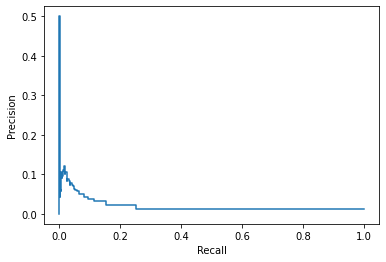

In [26]:
import numpy as np
# precision = np.append(precision, [1])
print(precision)
print(recall)
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## Prediction and Prediction Explainability 

In the next section we'll generate some predictions for the SCL test set. With these predictions, we'll also produce shap values to explain the predicitions. First we produce shap plots locally to the remote machine and pull back the created image. This plot includes the data values in the heatmap. This is to be used for diagnosing performance of the model.

The second shap function performs shap analysis remotely using the test set and pulls back the shap values, base_values and model expected value to be used on the orchestrator side. We use this to produce the prediction output with shap values csv deliverable.

### SHAP Plot for model diagnosis

2647.1393537521362


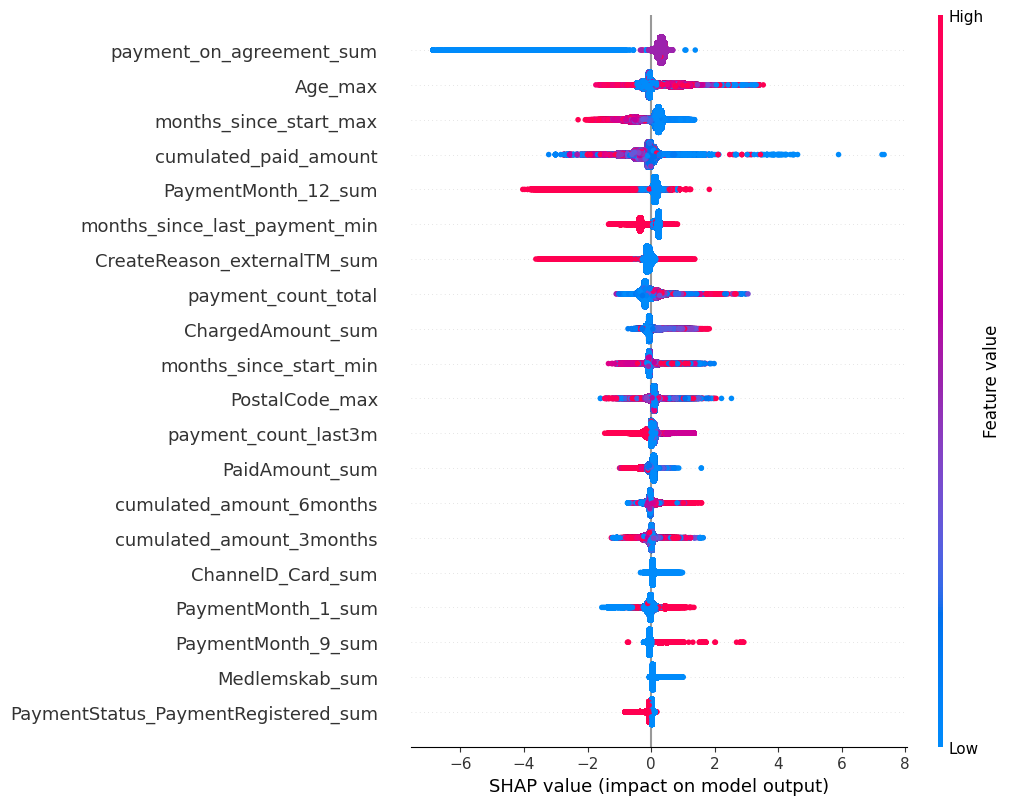

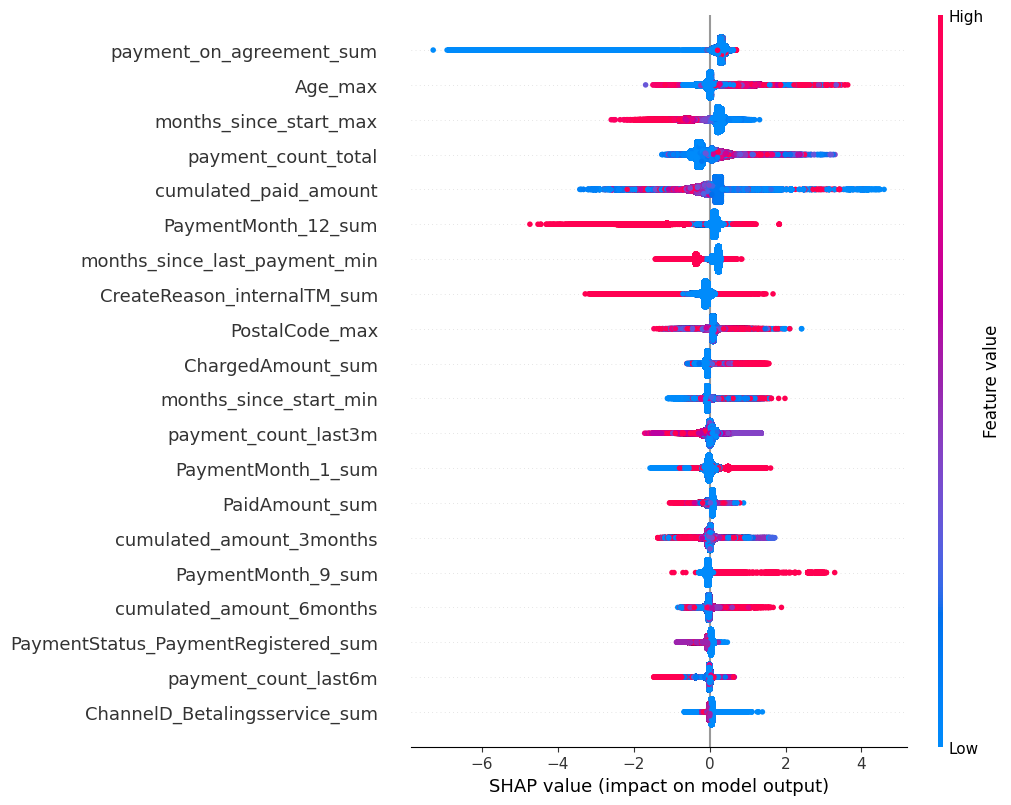

In [27]:
#For each dataset, generate shap images on the local machine, pull back the plots that were generated
start_time = time.time()

model.model = xgbmodel
model.shap(X_test)

print(time.time() - start_time)

### Create Prediction and Shap Values CSV for GFR

In [28]:
#Pull in our final set of safe functions
from sail.tmp import shap_private, get_tmp_fns

tmp_fns = get_tmp_fns()

In [29]:
#Push these safe functions to the remote VM

for vm in vmids:
        for key in tmp_fns:
            pushsafeobj(vm, tmp_fns[key])

In [30]:
#Generate predictions for csv file
preds = model.predict(X_test)

In [31]:
import pandas as pd

y_test_df = RemoteDataFrame(vmids[0], y_test[0], fns)
lab = y_test_df.value_counts()
temp_index = y_test_df.index
temp_index

explanation_values, explanation_base_values, expected_value = shap_private(vmids[0], xgbmodel, X_test[0], tmp_fns)

customer_guid = []
date = []
for i in range(0, len(temp_index)):
    customer_guid.append(temp_index[i][0])
    date.append(temp_index[i][1])

# Add references to customer instances
df1 = pd.DataFrame()
df1['CustomerGUID'] = customer_guid
df1['Date'] = date

#add predictions
df1['Predictions Probabilities'] = 1/(1+ np.exp(-preds[0]))
df1['Predictions Log Odds'] = preds[0]
df1['SHAP Base Values'] = explanation_base_values

#Add Explanation Values
df2 = pd.DataFrame()
df2 = pd.DataFrame(explanation_values)
df2.columns = cols
results_for_csv = pd.concat([df1, df2], axis=1, join='inner')
results_for_csv.to_csv('./predictions_federated_shap_GFR_test.csv')
results_for_csv.head()

['{06BE7B00-68A4-4FF4-B31C-BF781EE3AF48}']


,CustomerGUID,Date,Predictions Probabilities,Predictions Log Odds,SHAP Base Values,Age_max,ChargedAmount_sum,PostalCode_max,PaidAmount_sum,AgreementGUID_count,...,PaymentMonth_9_sum,PaymentMonth_10_sum,PaymentMonth_11_sum,PaymentMonth_12_sum,cumulated_paid_amount,cumulated_amount_3months,cumulated_amount_6months,payment_count_last3m,payment_count_last6m,payment_count_total
0,000042c4-ee04-e811-8112-5065f38be571,2020-01-01,0.005095,-5.274371,-5.517169,0.600507,0.164804,0.094589,0.008787,0.040425,...,-0.044342,0.008284,0.018393,0.129419,0.142273,-0.057255,-0.056129,0.143001,0.003623,-0.227210
1,000042c4-ee04-e811-8112-5065f38be571,2020-02-01,0.006758,-4.990312,-5.517169,0.013366,-0.062360,0.084539,0.084996,-0.013564,...,-0.073683,0.000385,-0.013907,0.111274,0.175565,-0.030920,-0.016953,-0.031793,-0.013019,-0.310319
2,000042c4-ee04-e811-8112-5065f38be571,2020-03-01,0.005001,-5.293078,-5.517169,0.505959,0.346830,0.248572,-0.479804,0.000445,...,-0.039022,0.034928,0.086548,0.182797,-0.017955,0.114366,-0.084057,0.080172,0.006258,-0.121572
3,000042c4-ee04-e811-8112-5065f38be571,2020-04-01,0.011337,-4.468250,-5.517169,-0.048976,-0.022247,0.107282,0.088255,-0.011049,...,-0.051006,0.013096,0.016259,0.209527,0.293150,0.107000,-0.019562,-0.007709,0.006531,-0.231659
4,000042c4-ee04-e811-8112-5065f38be571,2020-05-01,0.009441,-4.653199,-5.517169,-0.110724,-0.029572,0.087083,0.100368,-0.013533,...,-0.051085,0.014747,0.016829,0.197379,0.423684,0.062886,-0.030613,0.019141,-0.013168,-0.211361


### Display shap values for model analysis GFR

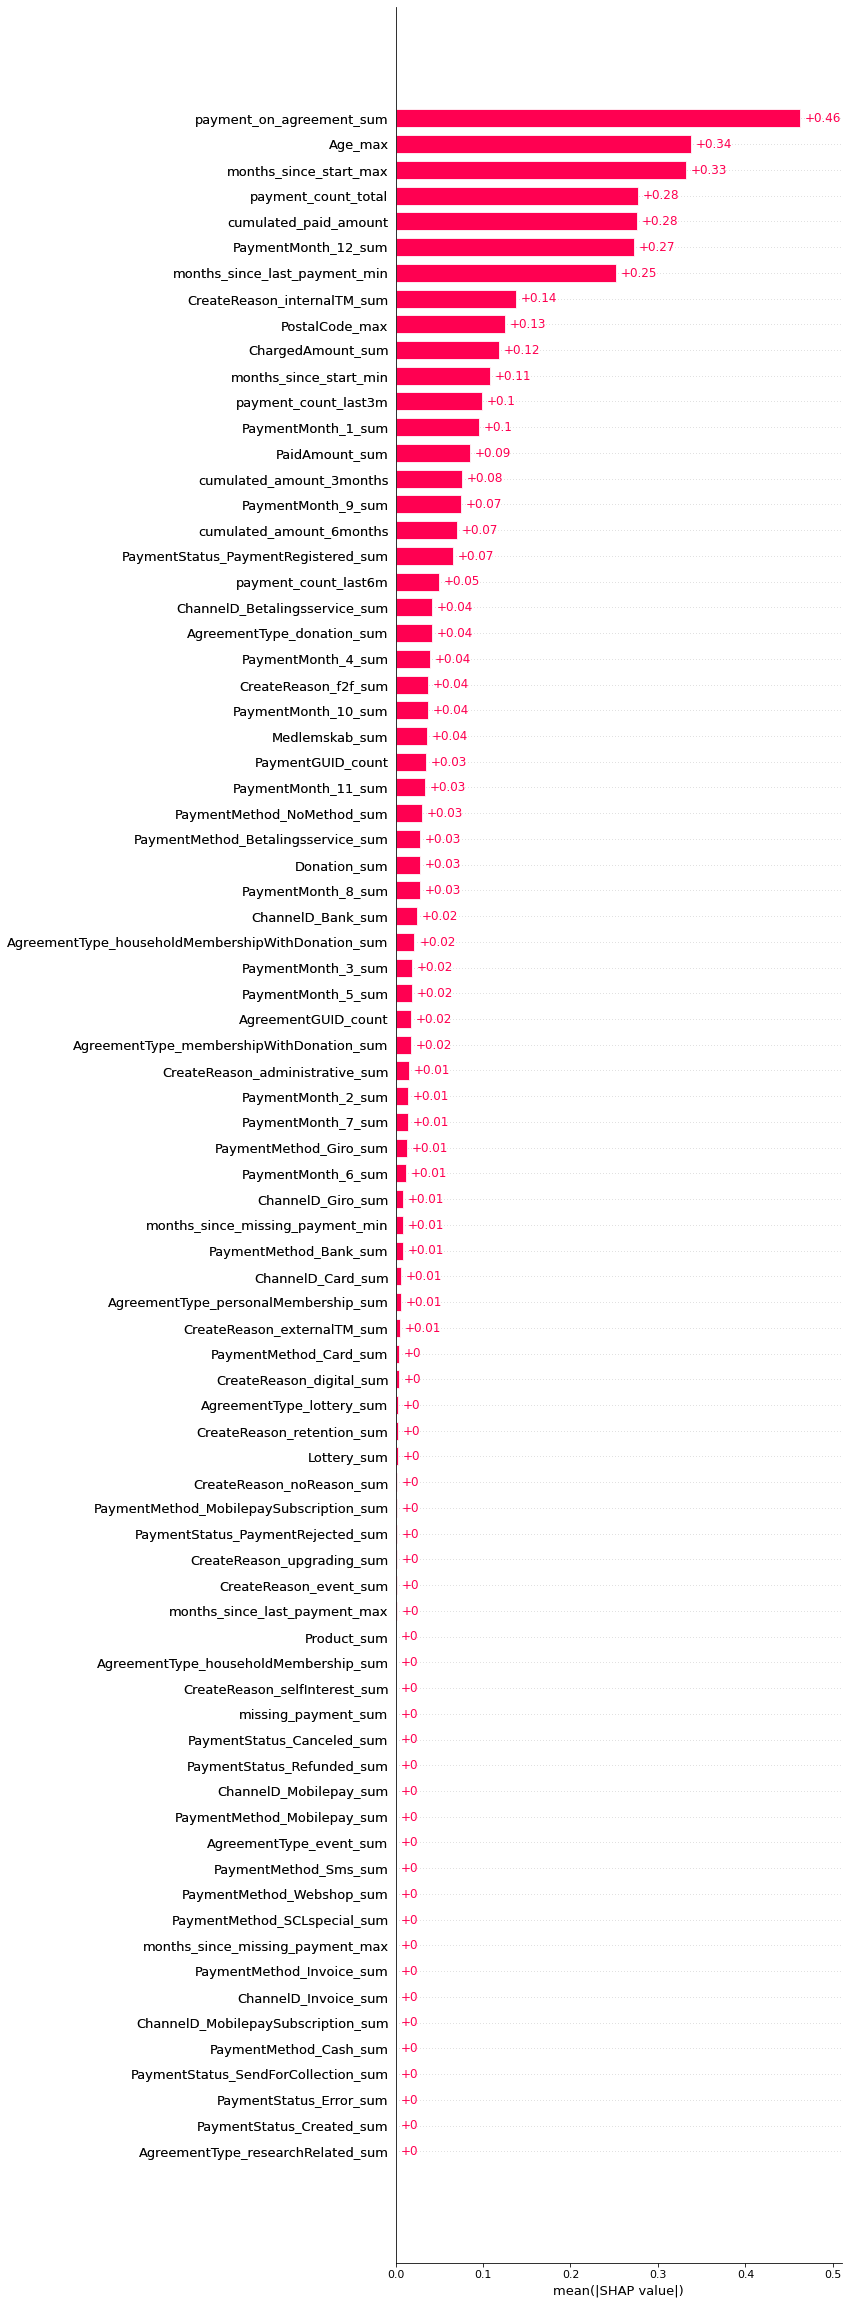

None


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


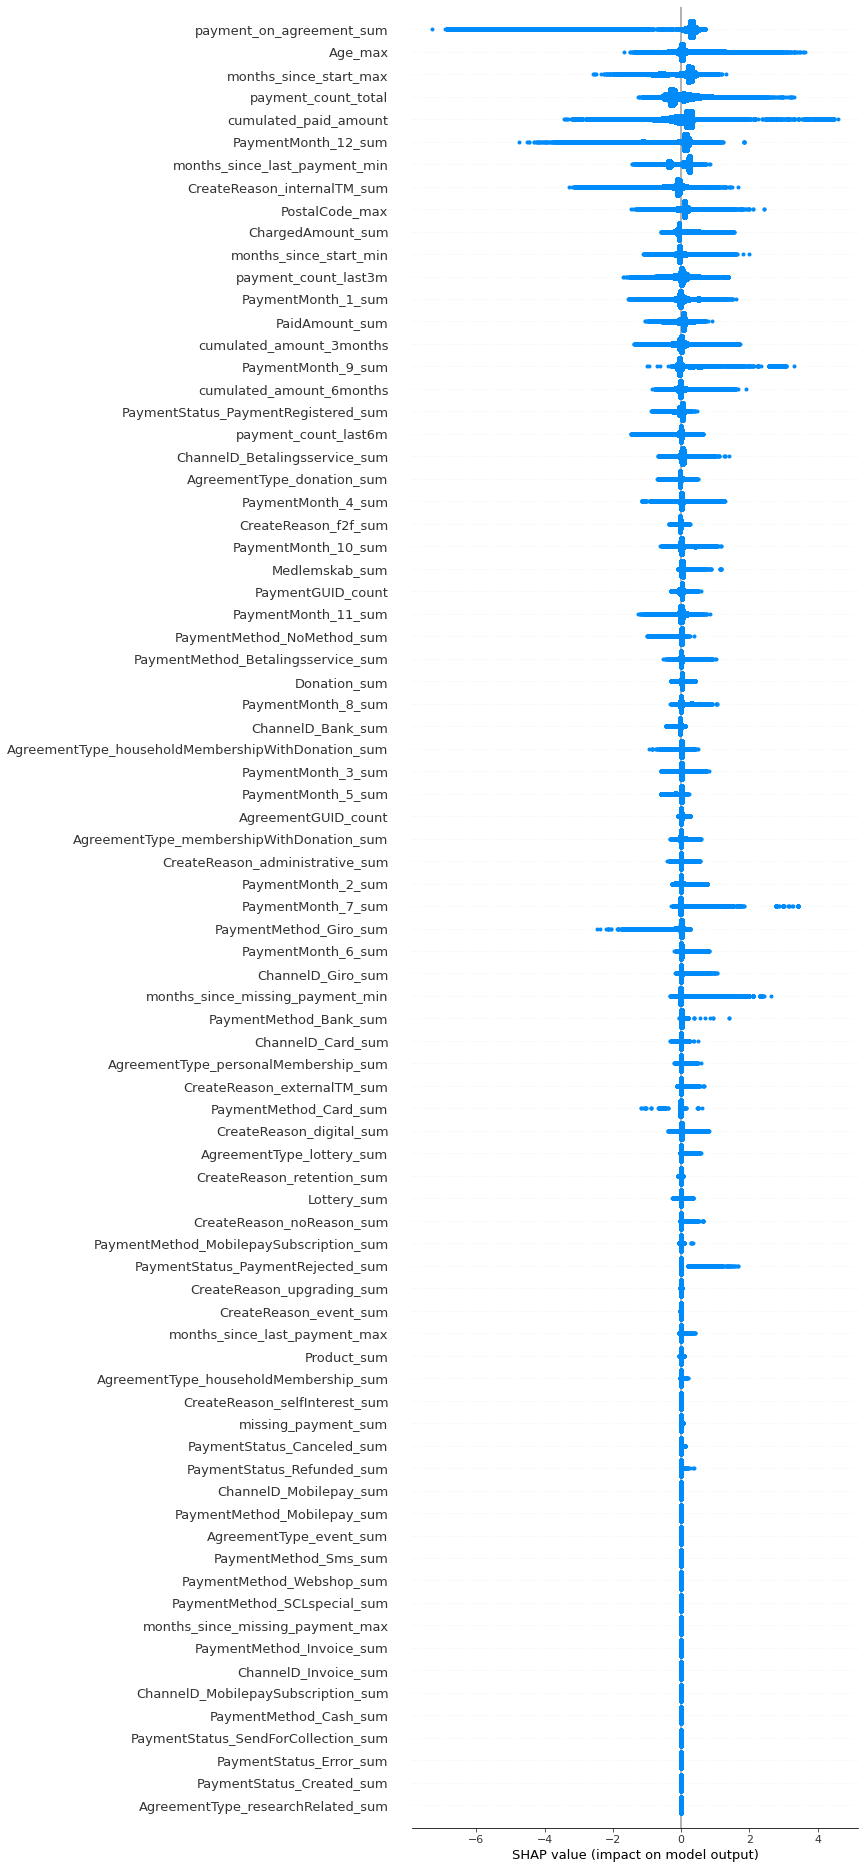

None


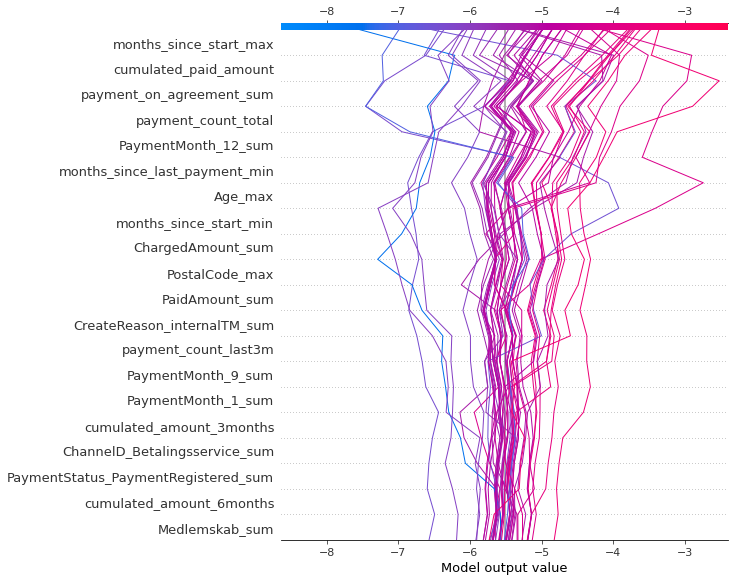

None


In [32]:
import shap

explanation = shap.Explanation(explanation_values, base_values=explanation_base_values, feature_names=cols)
print(shap.plots.bar(explanation, max_display=len(cols)))
print(shap.plots.beeswarm(explanation, max_display=len(cols)))
print(shap.decision_plot(expected_value, explanation.values[:50], cols))

### Create Prediction and Shap Values CSV for SCL

In [33]:

y_test_df = RemoteDataFrame(vmids[1], y_test[1], fns)
lab = y_test_df.value_counts()
temp_index = y_test_df.index
temp_index

explanation_values, explanation_base_values, expected_value = shap_private(vmids[1], xgbmodel, X_test[1], tmp_fns)

customer_guid = []
date = []
for i in range(0, len(temp_index)):
    customer_guid.append(temp_index[i][0])
    date.append(temp_index[i][1])

# Add references to customer instances
df1 = pd.DataFrame()
df1['CustomerGUID'] = customer_guid
df1['Date'] = date

#add predictions
df1['Predictions Probabilities'] = 1/(1+ np.exp(-preds[1]))
df1['Predictions Log Odds'] = preds[1]
df1['SHAP Base Values'] = explanation_base_values

#Add Explanation Values
df2 = pd.DataFrame()
df2 = pd.DataFrame(explanation_values)
df2.columns = cols
results_for_csv = pd.concat([df1, df2], axis=1, join='inner')
results_for_csv.to_csv('./predictions_federated_shap_SCL_test.csv')
results_for_csv.head()

['{EC3F2744-98E0-4D33-B5E4-612B297064B1}']


,CustomerGUID,Date,Predictions Probabilities,Predictions Log Odds,SHAP Base Values,Age_max,ChargedAmount_sum,PostalCode_max,PaidAmount_sum,AgreementGUID_count,...,PaymentMonth_9_sum,PaymentMonth_10_sum,PaymentMonth_11_sum,PaymentMonth_12_sum,cumulated_paid_amount,cumulated_amount_3months,cumulated_amount_6months,payment_count_last3m,payment_count_last6m,payment_count_total
0,000226bd-8955-4e94-becd-47ff50c1704c,2020-10-01,2.866711e-06,-12.762342,-5.517169,-0.087866,-0.066066,0.172321,0.052418,-0.006651,...,-0.077935,0.124563,-0.020812,-0.090740,-1.613936,0.002612,-0.234796,0.016093,-0.125854,-0.345815
1,000226bd-8955-4e94-becd-47ff50c1704c,2020-11-01,2.101806e-05,-10.770107,-5.517169,0.053365,-0.069752,0.087927,0.080710,-0.005776,...,-0.078298,0.051761,0.440176,-0.112196,-1.410266,0.032036,-0.178954,0.118260,-0.116696,-0.218705
2,000226bd-8955-4e94-becd-47ff50c1704c,2020-12-01,1.362316e-04,-8.901018,-5.517169,-0.219027,-0.063946,0.120266,0.123149,-0.004905,...,-0.016396,0.030870,-0.019301,0.521477,-1.817295,0.152258,-0.170690,0.168494,-0.048812,-0.035258
3,000226bd-8955-4e94-becd-47ff50c1704c,2021-01-01,6.043517e-07,-14.319109,-5.517169,-0.227885,-0.067064,0.071228,0.058478,-0.004516,...,-0.068560,0.021714,-0.040773,-0.082998,-1.576072,-0.059117,-0.148674,0.068823,-0.163722,-0.589011
4,000226bd-8955-4e94-becd-47ff50c1704c,2021-02-01,5.122735e-06,-12.181817,-5.517169,-0.016773,-0.070215,0.078650,0.069306,-0.005776,...,-0.078029,0.026361,-0.055030,-0.136628,-1.578905,-0.017194,-0.183241,0.062298,-0.120882,-0.340270


### Display shap values for model analysis SCL

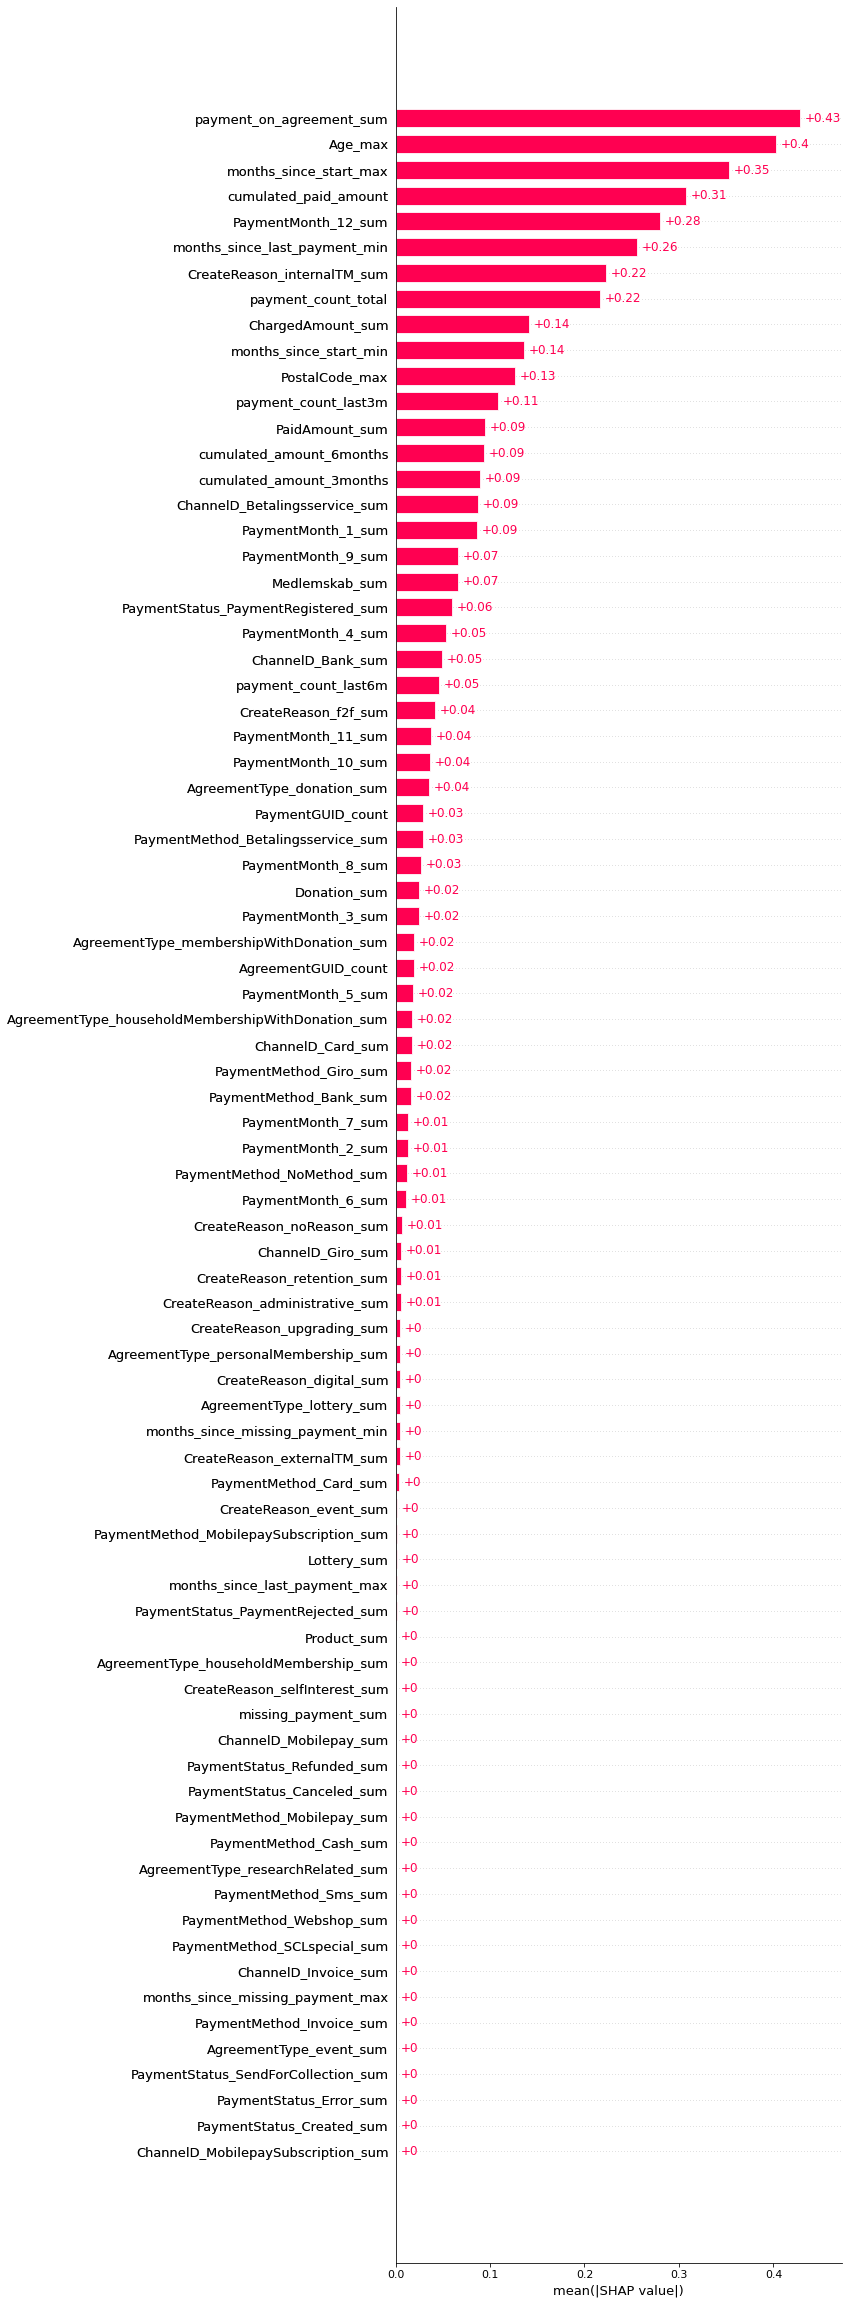

None


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


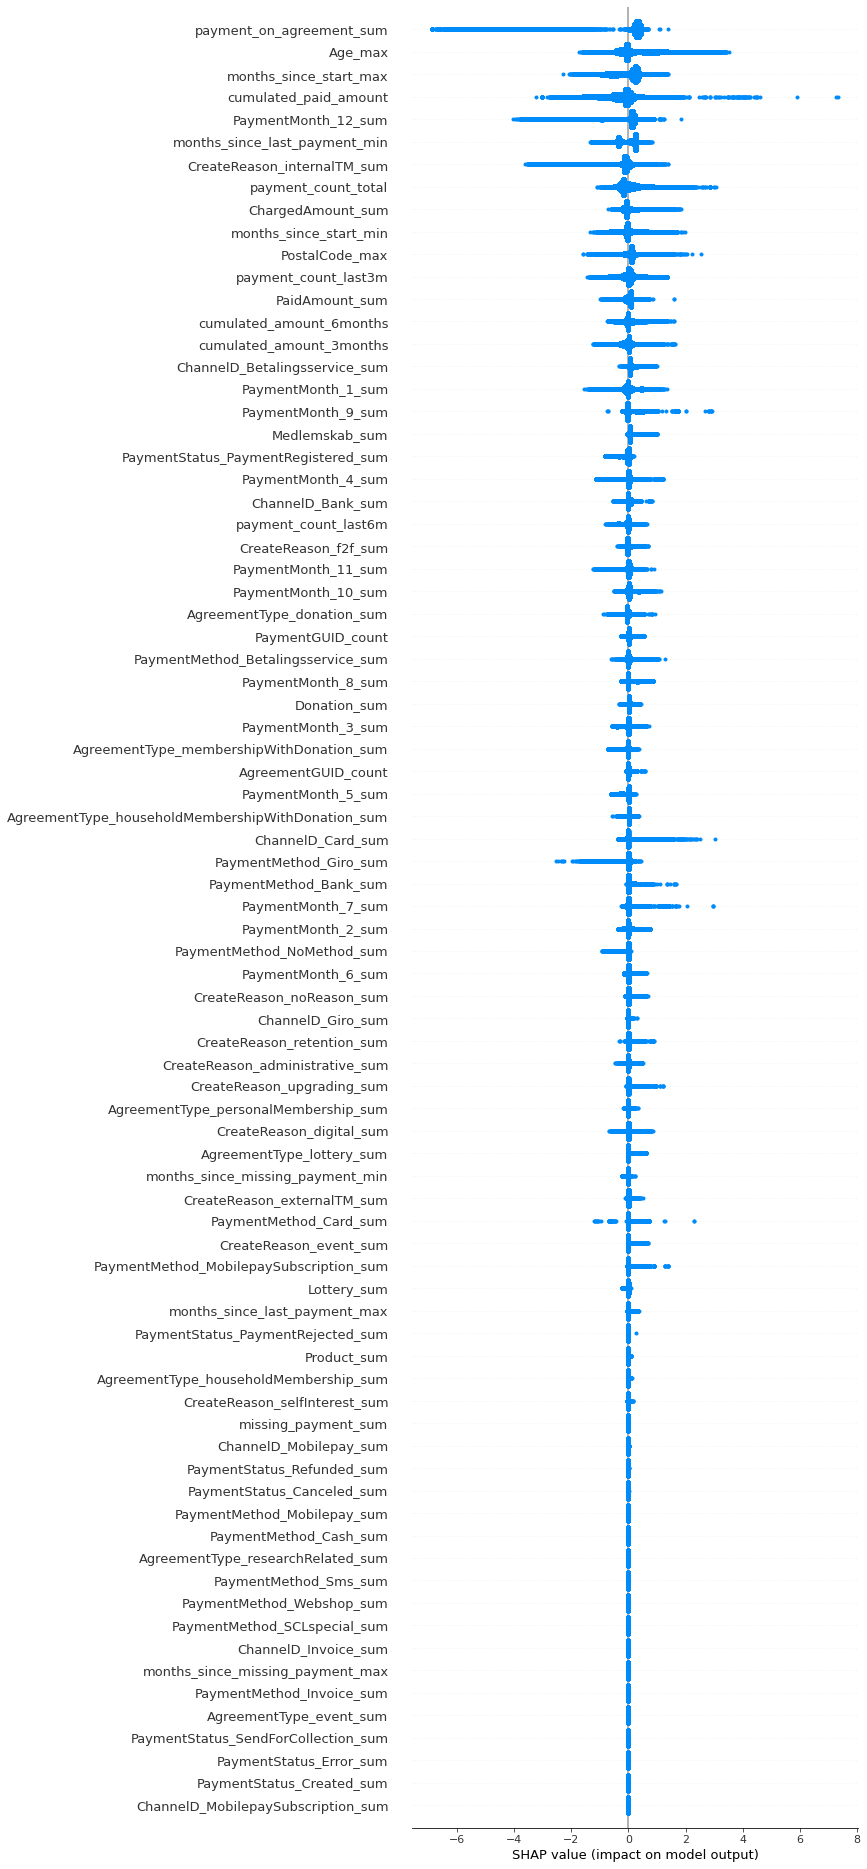

None


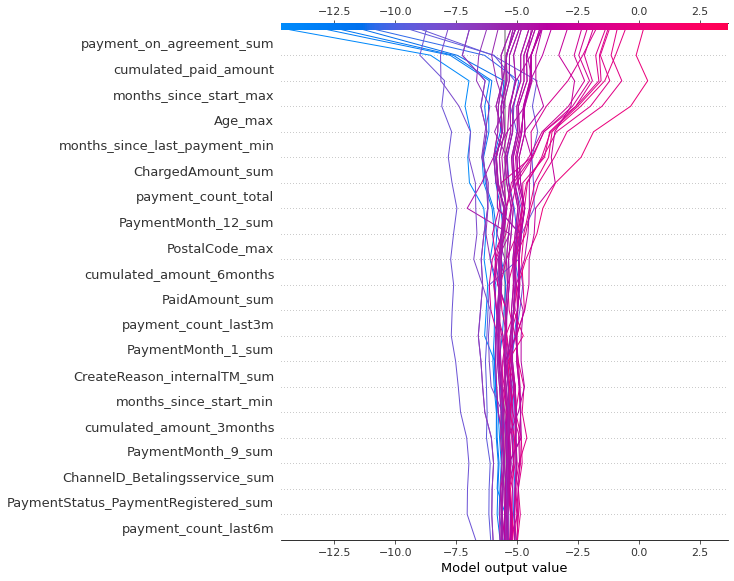

None


In [34]:
explanation = shap.Explanation(explanation_values, base_values=explanation_base_values, feature_names=cols)
print(shap.plots.bar(explanation, max_display=len(cols)))
print(shap.plots.beeswarm(explanation, max_display=len(cols)))
print(shap.decision_plot(expected_value, explanation.values[:50], cols))